# ResNet50


In [1]:
# Upgrade and install dependencies
!pip install --upgrade pip
!pip install sklearn
!pip install seaborn

In [2]:
# Import Libraries
import random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import confusion_matrix

In [3]:
# Set memory growth and list GPU
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("TensorFlow version: ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU name: ", tf.test.gpu_device_name())

TensorFlow version:  2.8.0
Num GPUs Available:  1
GPU name:  /device:GPU:0


# Preparation of the data sets


In [4]:
# Set image_dataset_from_directory parameters
LABELS = "inferred"
LABEL_MODE = "int"
COLOR_MODE = "rgb"
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
SHUFFLE = True
CROP_TO_ASPECT_RATIO = True

# For scaling and optimizing
AUTOTUNE = tf.data.AUTOTUNE

# Used for splitting val_ds
def is_test(x, y):
    return x % 2 == 0

def is_val(x, y):
    return not is_test(x, y)

def get_sets(TRAIN_DIRECTORY, VALIDATION_SPLIT, TEST_DIRECTORY):
    
    SEED = random.randint(0, 2000)

    # Create training set
    train_ds = keras.preprocessing.image_dataset_from_directory(
        directory = TRAIN_DIRECTORY,
        labels = LABELS, 
        label_mode = LABEL_MODE,
        color_mode = COLOR_MODE,
        batch_size = BATCH_SIZE,
        image_size = IMAGE_SIZE,
        shuffle = SHUFFLE,
        seed = SEED,
        validation_split=VALIDATION_SPLIT,
        subset="training",
        crop_to_aspect_ratio = CROP_TO_ASPECT_RATIO
    )
    # Create validation set
    val_ds = keras.preprocessing.image_dataset_from_directory(
        directory = TRAIN_DIRECTORY,
        labels = LABELS, 
        label_mode = LABEL_MODE,
        color_mode = COLOR_MODE,
        batch_size = BATCH_SIZE,
        image_size = IMAGE_SIZE,
        shuffle = SHUFFLE,
        seed = SEED,
        validation_split = VALIDATION_SPLIT, 
        subset = "validation",    
        crop_to_aspect_ratio = CROP_TO_ASPECT_RATIO
    )
    # Create test set
    test_ds = keras.preprocessing.image_dataset_from_directory(
        directory = TEST_DIRECTORY,
        labels = LABELS, 
        label_mode = LABEL_MODE,
        color_mode = COLOR_MODE,
        batch_size = BATCH_SIZE,
        image_size = IMAGE_SIZE,
        shuffle = SHUFFLE,
        seed = SEED,
        validation_split = None, 
        subset = None,    
        crop_to_aspect_ratio = CROP_TO_ASPECT_RATIO
    )

    # Optimizing
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
    
    return train_ds, val_ds, test_ds

# Creating model functions

In [5]:
# Method for creating the model
def create_model():

    # Import base model and freeze layers
    base_model = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet', 
                                                         include_top = False, 
                                                         input_shape = (224,224,3))
    for layer in base_model.layers:
        layer.trainable = False
        
    # Creating dictionary that maps layer names to the layers
    layer_dict = dict([(layer.name, layer) for layer in base_model.layers])
    # Getting output tensor of the last layer that we want to include
    x = layer_dict['conv5_block3_out'].output
    
    # Add custom layers
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.25)(x) 
    predictions = Dense(1, activation = None)(x)
    model = tf.keras.Model(inputs = base_model.input, outputs = predictions)
    
    # Compile model
    adamax = Adamax(learning_rate = 1e-04)
    model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=adamax,
    metrics=["binary_accuracy"])
    
    return model

# Plotting

In [6]:
# Method for plotting confusion matrix
def plot_cm(cf_matrix):
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

# Training

In [7]:
# Initialize metric arrays 
accuracy_list = []
precision_0_list = []
recall_0_list = []
precision_1_list = []
recall_1_list = []
f1_0_list=[]
f1_1_list=[]
cm = np.array([[0,0],[0,0]])

# Run loop 10 times
for lp in range(10):
    
    print("\n<*************************************************************************************************************>")
    print("\nIteration nr: " + str(lp + 1))
    print("\n<*************************************************************************************************************>\n")
    
    # Create the model
    model = create_model()

    # Get datasets
    train_ds, val_ds, test_ds = get_sets("datasets/Split_1-Binary-Augmented", 0.2, "datasets/Split_0-Binary")
    
    # Train model
    model.fit(
        train_ds, 
        epochs=100, 
        batch_size=32, 
        validation_data=val_ds,
        callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights = True)
        ]
    )
        
    # Create set for predictions
    test_batches = tf.data.experimental.cardinality(test_ds)
    test_dataset = test_ds.take(test_batches // 5)

    # Retrieve a batch of images from the test set
    image_batch, label_batch = test_dataset.as_numpy_iterator().next()
    predictions = model.predict_on_batch(image_batch).flatten()

    # Apply a sigmoid since our model returns logits
    predictions = tf.nn.sigmoid(predictions)
    predictions = tf.where(predictions < 0.5, 0, 1)
    
    # Calculate metrics
    tn, fp, fn, tp = confusion_matrix(label_batch, predictions.numpy()).ravel()
    cm += confusion_matrix(label_batch, predictions.numpy())
    
    # Accuracy
    acc = (tn+tp)*100/(tp+tn+fp+fn) 
    accuracy_list.append(acc)

    # Precision class 1
    if (tp+fp) > 0:
        precision_1 = (float(tp))/float(tp+fp)
    else: 
        precision_1 = 0.0
    precision_1_list.append(precision_1)

    # Recall class 1
    recall_1 = float(tp)/(tp+fn) 
    recall_1_list.append(recall_1)

    # Precision class 0
    precision_0 = (float(tn))/(tn+fn)
    precision_0_list.append(precision_0)

    # Recall class 0 
    recall_0 = float(tn)/(tn+fp) 
    recall_0_list.append(recall_0)

    # F1 Score class 1
    if (precision_1 + recall_1) > 0:
        f1_1 = (2*precision_1*recall_1)/(precision_1 + recall_1)
    else:
        f1_1=0.0
    f1_1_list.append(f1_1)
    
    # F1 Score class 0
    f1_0 = (2*precision_0*recall_0)/(precision_0 + recall_0)
    f1_0_list.append(f1_0)


<*************************************************************************************************************>

Iteration nr: 1

<*************************************************************************************************************>

Found 45538 files belonging to 2 classes.
Using 36431 files for training.
Found 45538 files belonging to 2 classes.
Using 9107 files for validation.
Found 23061 files belonging to 2 classes.
Epoch 1/100
1139/1139 [==============================] - 145s 123ms/step - loss: 0.3853 - binary_accuracy: 0.8538 - val_loss: 0.2538 - val_binary_accuracy: 0.9000
Epoch 2/100
1139/1139 [==============================] - 137s 121ms/step - loss: 0.1758 - binary_accuracy: 0.9282 - val_loss: 0.2135 - val_binary_accuracy: 0.9172
Epoch 3/100
1139/1139 [==============================] - 137s 120ms/step - loss: 0.1096 - binary_accuracy: 0.9586 - val_loss: 0.1962 - val_binary_accuracy: 0.9223
Epoch 4/100
1139/1139 [==============================] - 136s 120ms/step - l

Found 45538 files belonging to 2 classes.
Using 36431 files for training.
Found 45538 files belonging to 2 classes.
Using 9107 files for validation.
Found 23061 files belonging to 2 classes.
Epoch 1/100
1139/1139 [==============================] - 156s 134ms/step - loss: 0.3584 - binary_accuracy: 0.8579 - val_loss: 0.2260 - val_binary_accuracy: 0.9052
Epoch 2/100
1139/1139 [==============================] - 151s 132ms/step - loss: 0.1638 - binary_accuracy: 0.9338 - val_loss: 0.1833 - val_binary_accuracy: 0.9264
Epoch 3/100
1139/1139 [==============================] - 151s 133ms/step - loss: 0.0998 - binary_accuracy: 0.9618 - val_loss: 0.1943 - val_binary_accuracy: 0.9306
Epoch 4/100
1139/1139 [==============================] - 151s 133ms/step - loss: 0.0695 - binary_accuracy: 0.9727 - val_loss: 0.1901 - val_binary_accuracy: 0.9359
Epoch 5/100
1139/1139 [==============================] - 152s 134ms/step - loss: 0.0450 - binary_accuracy: 0.9832 - val_loss: 0.1614 - val_binary_accuracy: 0

1139/1139 [==============================] - 139s 122ms/step - loss: 0.0674 - binary_accuracy: 0.9740 - val_loss: 0.1781 - val_binary_accuracy: 0.9335
Epoch 5/100
1139/1139 [==============================] - 138s 121ms/step - loss: 0.0459 - binary_accuracy: 0.9830 - val_loss: 0.1778 - val_binary_accuracy: 0.9348
Epoch 6/100
1139/1139 [==============================] - 137s 120ms/step - loss: 0.0316 - binary_accuracy: 0.9896 - val_loss: 0.2044 - val_binary_accuracy: 0.9281
Epoch 7/100
1139/1139 [==============================] - 135s 118ms/step - loss: 0.0202 - binary_accuracy: 0.9934 - val_loss: 0.1963 - val_binary_accuracy: 0.9349
Epoch 8/100
1139/1139 [==============================] - 135s 118ms/step - loss: 0.0153 - binary_accuracy: 0.9957 - val_loss: 0.1618 - val_binary_accuracy: 0.9484
Epoch 9/100
1139/1139 [==============================] - 134s 118ms/step - loss: 0.0105 - binary_accuracy: 0.9973 - val_loss: 0.1650 - val_binary_accuracy: 0.9473
Epoch 10/100
1139/1139 [==========

# Results

In [8]:
# Average values
print ("Accuracy average:", sum(accuracy_list)/len(accuracy_list))
print ("Accuracy list:", accuracy_list)
print ("\nPrecision_1:", sum(precision_1_list)/len(precision_1_list))
print ("Presicion_0:", sum(precision_0_list)/len(precision_0_list))
print ("\nRecall_1:", sum(recall_1_list)/len(recall_1_list))
print ("Recall_0:", sum(recall_0_list)/len(recall_0_list))
print ("\nF1_1:", sum(f1_1_list)/len(f1_1_list))
print ("F1_0:", sum(f1_0_list)/len(f1_0_list))

Accuracy average: 80.3125
Accuracy list: [84.375, 75.0, 81.25, 78.125, 90.625, 87.5, 71.875, 78.125, 68.75, 87.5]

Precision_1: 0.7552214452214452
Presicion_0: 0.8382603357566341

Recall_1: 0.6435897435897436
Recall_0: 0.8772100211001813

F1_1: 0.6781190476190475
F1_0: 0.8543815860443766


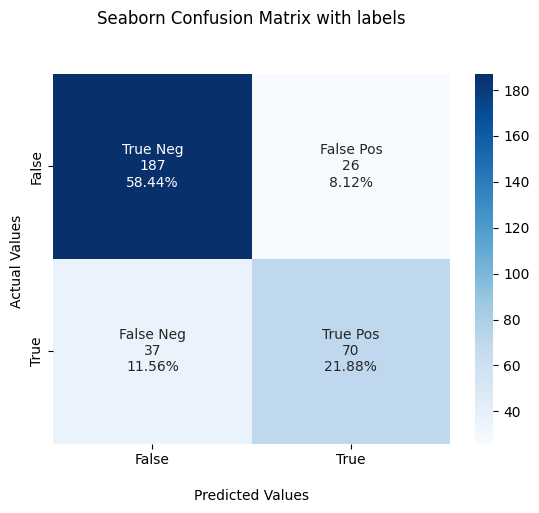

In [9]:
# Plot confusion matrix from average
plot_cm(cm)